In [150]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from data_setup import create_datasets
from attacks import pgd, fgsm, deepfool, one_pixel
from defenses import rfgsm_defense
import random

In [103]:
BATCH_SIZE = 128
eps = 4e-2
eta = eps/5
num_iter = 40

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

def transform(img, label):
    img = tf.expand_dims(img, -1)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

train_dataset, test_dataset = create_datasets(x_train,
                                              y_train,
                                              x_test,
                                              y_test,
                                              transform,
                                              BATCH_SIZE)

In [154]:
model = tf.keras.models.load_model('models/dense')

In [12]:
x,y = next(iter(train_dataset))

Use the PGD attack on the pre-trained classifier.

In [122]:
def find_class_and_prob(img):
    """Given a batch of images, find the predicted classes, and their respective probabilities."""
    num_imgs = img.shape[0]
    y_pred = model(img)
    probs_pred = tf.nn.softmax(y_pred)
    classes_pred = tf.math.argmax(y_pred, axis = -1)
    classes_prob = probs_pred.numpy()[np.arange(num_imgs),classes_pred.numpy()]
    return classes_pred, classes_prob

In [155]:
pgd_attacker = pgd.PGD(model, eta, eps, num_iter)
x_adv = pgd_attacker.generate(x,y)

In [156]:
classes_pred, probs = find_class_and_prob(x)
classes_pred_adv, probs_adv = find_class_and_prob(x_adv)

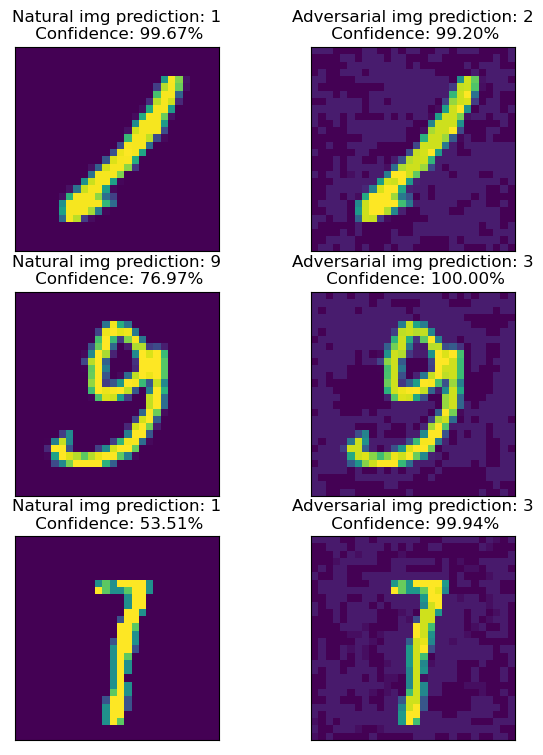

In [157]:
num_samples = 3
rand_idxs = np.random.randint(BATCH_SIZE, size = num_samples)

fig, ax = plt.subplots(nrows = num_samples, ncols = 2, figsize = (7,9))
for row, idx in enumerate(rand_idxs):
    ax[row,0].imshow(x[idx])
    ax[row,1].imshow(x_adv[idx])
    ax[row,0].set_title(f'Natural img prediction: {classes_pred[idx].numpy()}\n Confidence: {100*probs[idx]:.2f}%')
    ax[row,1].set_title(f'Adversarial img prediction: {classes_pred_adv[idx].numpy()}\n Confidence: {100*probs_adv[idx]:.2f}%')
plt.setp(ax, xticks=[], yticks=[]);

Applying the FGSM, PGD, DeepFool, and One Pixel attack on a specific image.

In [158]:
fgsm_attacker = fgsm.FGSM(model, eps)
deepfool_attacker = deepfool.DeepFool(model, eta = 1e-3, num_iter = 20)
one_pixel_attacker = one_pixel.OnePixel(model)

In [159]:
rand_idx = random.randint(0,len(x_train)-1)

img = tf.convert_to_tensor(x_train[rand_idx])[tf.newaxis, :,:,tf.newaxis]
img = tf.cast(img, tf.float32)/255.
label = y_train[:,None][rand_idx]
label = tf.convert_to_tensor(label)



In [160]:
def plot_attacks(img, label, target = 3):

    natural_class, natural_prob = find_class_and_prob(img)

    img_fgsm = fgsm_attacker.generate(img, label)
    fgsm_class, fgsm_prob = find_class_and_prob(img_fgsm)

    img_pgd = pgd_attacker.generate(img, label)
    pgd_class, pgd_prob = find_class_and_prob(img_pgd)

    img_deepfool = deepfool_attacker.generate(img)
    deepfool_class, deepfool_prob = find_class_and_prob(img_deepfool)

    img_one_pixel = one_pixel_attacker.generate(img, target = 3)
    one_pixel_class, one_pixel_prob = find_class_and_prob(img_one_pixel)

    fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (13,3))
    ax[0].imshow(img[0])
    ax[0].set_title(f'Natural image:\nPrediction: {natural_class[0]}\n Confidence: {100*natural_prob[0]:.2f}%')
    ax[1].imshow(img_fgsm[0])
    ax[1].set_title(f'FGSM:\nPrediction: {fgsm_class[0]}\n Confidence: {100*fgsm_prob[0]:.2f}%')
    ax[2].imshow(img_pgd[0])
    ax[2].set_title(f'PGD:\nPrediction: {pgd_class[0]}\n Confidence: {100*pgd_prob[0]:.2f}%')
    ax[3].imshow(img_deepfool[0])
    ax[3].set_title(f'DeepFool:\nPrediction: {deepfool_class[0]}\n Confidence: {100*deepfool_prob[0]:.2f}%')
    ax[4].imshow(img_one_pixel[0])
    ax[4].set_title(f'One Pixel:\nPrediction: {one_pixel_class[0]}\n Confidence: {100*one_pixel_prob[0]:.2f}%')
    plt.setp(ax, xticks=[], yticks=[]);

Iteration 0
norm of modification: 0.5310701727867126
Iteration 1
norm of modification: 0.032927144318819046
Network fooled
Success? True
Reason for termination: Optimization terminated successfully.


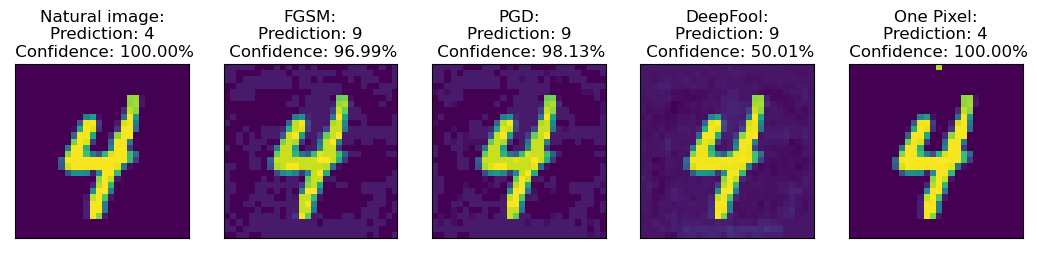

In [161]:
plot_attacks(img, label)

Let's adversarially train the model against PGD attacks.

In [162]:
trainer = rfgsm_defense.RFGSM(model, eps)
trainer.fit(train_dataset, test_dataset)

Epoch 0
Calculating validation metrics
validation loss: 0.068857342004776
validation accuracy: 0.9779999852180481
validation adversarial loss: 0.5092417001724243
validation adversarial accuracy: 0.8446999788284302
Epoch 1
Calculating validation metrics
validation loss: 0.06600793451070786
validation accuracy: 0.978600025177002
validation adversarial loss: 0.39417940378189087
validation adversarial accuracy: 0.8740000128746033
Epoch 2
Calculating validation metrics
validation loss: 0.06337327510118484
validation accuracy: 0.9801999926567078
validation adversarial loss: 0.3386877477169037
validation adversarial accuracy: 0.8939999938011169
Epoch 3
Calculating validation metrics
validation loss: 0.06135027855634689
validation accuracy: 0.9805999994277954
validation adversarial loss: 0.3133562207221985
validation adversarial accuracy: 0.8999999761581421
Epoch 4
Calculating validation metrics
validation loss: 0.062099479138851166
validation accuracy: 0.9807000160217285
validation adversaria

Iteration 0
norm of modification: 1.686374545097351
Network fooled
Success? True
Reason for termination: Optimization terminated successfully.


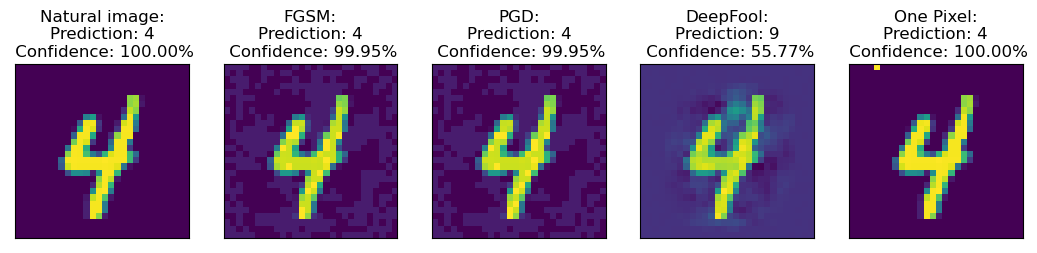

In [163]:
plot_attacks(img, label)

Note that after adversarial fine-tuning, the model is much more robust to adversarial examples. The exception is the DeepFool attack, but this algorithm by design iterates until it fools the classifier.